# Head and brain tissues segmentation form MRI scans

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
from tensorflow.keras.models import load_model
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2
from volume import prepare_vols

In [3]:
# Define constants

HOUNSFIELD_MIN = 0
HOUNSFIELD_MAX = 65535
# HOUNSFIELD_MAX = 4500
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True
SLICE_Y = True
SLICE_Z = True

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [4]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [6]:
targetName = 'inferance'
targetImagePath = r"C:\Users\samisharabi\Documents\UTAR\masters\UTAR\ADNI database\ADNI\941_S_1311\MPR-R__GradWarp__B1_Correction__N3__Scaled\2007-09-27_15_35_45.0\S40710\ADNI_941_S_1311_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080313131733540_S40710_I97341.nii"
targetMaskPath  = r"C:\Users\samisharabi\Documents\UTAR\masters\UTAR\ADNI database\ADNI\941_S_1311\MPR-R__GradWarp__B1_Correction__N3__Scaled\2007-09-27_15_35_45.0\S40710\ADNI_941_S_1311_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080313131733540_S40710_I97341.nii"


x , imgTargetNii = prepare_vols(targetImagePath,out_format="keep",write_vols=False)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()

In [8]:
# with tf.device('/cpu:0'):

model = load_model(r'C:\Users\samisharabi\Documents\UTAR\masters\UTAR\Software\mansour v2\model_CSF.h5',compile=False)

In [9]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [10]:
sliceIndex = 119

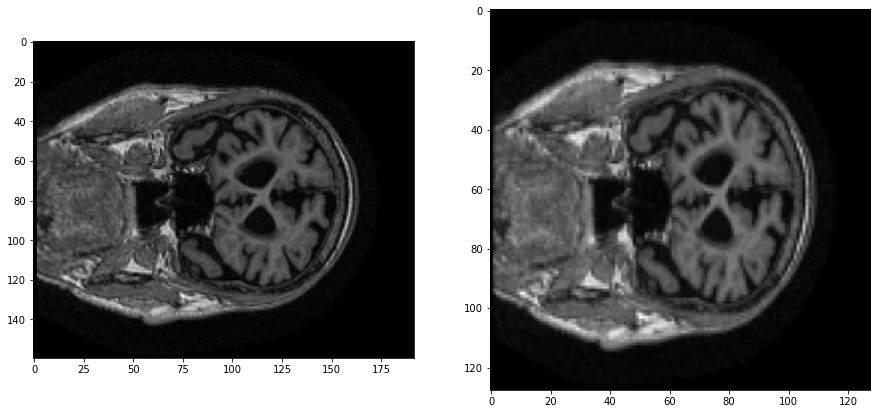

((160, 192), (128, 128))

In [11]:
#Single slicing prediction
plt.figure(figsize=(15,15))
imgSlice = imgTarget[:,sliceIndex,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
cv2.imwrite("D:\Git\MRI_Segmentation\slice101.png",imgSliceScaled*255)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

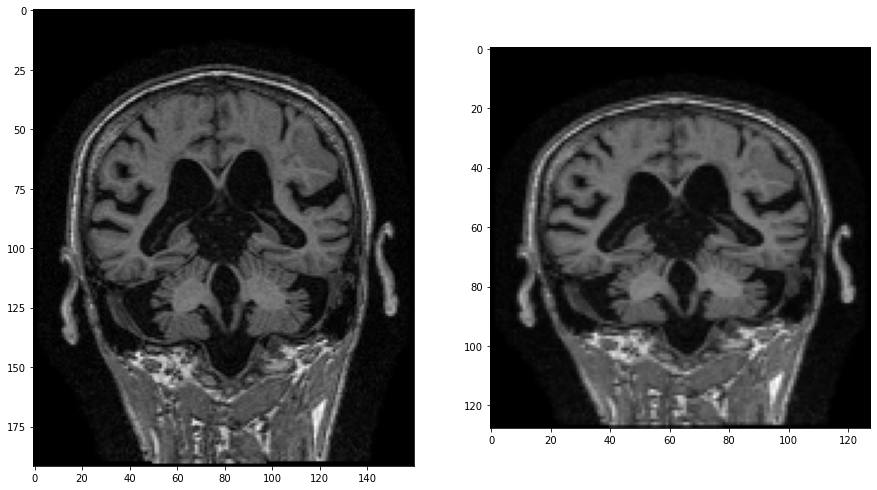

((192, 160), (128, 128))

In [12]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[:,sliceIndex,:]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
cv2.imwrite("D:\Git\MRI_Segmentation\mask101.png",maskSliceScaled)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

(160, 192)


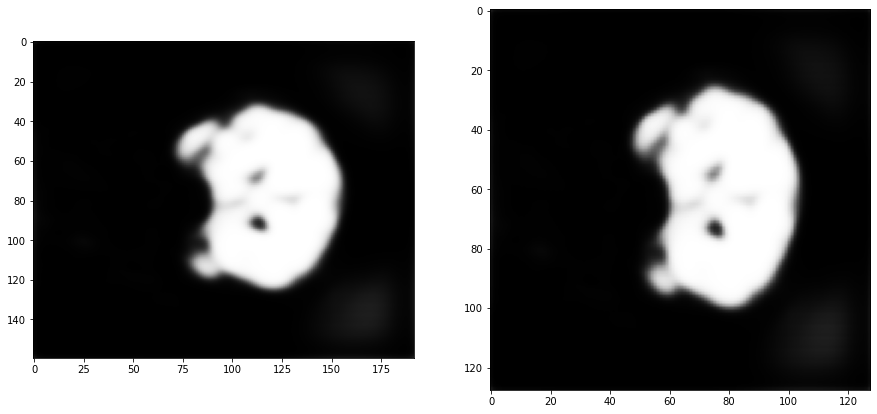

((160, 192), (128, 128))

In [13]:
with tf.device('/cpu:0'):
# Predict with UNET model
    plt.figure(figsize=(15,15))
    imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
    maskPredict = model.predict(imageInput)[0,:,:,1]
    maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
    print(maskPredictScaled.shape)
    plt.subplot(1,2,2)
    plt.imshow(maskPredict, cmap='gray')
    plt.subplot(1,2,1)
    plt.imshow(maskPredictScaled, cmap='gray')
    plt.show()
maskPredictScaled.shape, maskPredict.shape

In [14]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,:]
            # print("1", tmp.shape, np.max(tmp))
            tmp = np.argmax(tmp, axis=-1)
            # print("2", tmp.shape, np.max(tmp))
            tmp = np.array(tmp, dtype='uint8')
            # print("3", tmp.shape, np.max(tmp))
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,:]
            tmp = np.argmax(tmp, axis=-1)
            tmp = np.array(tmp, dtype='uint8')
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,:]
            tmp = np.argmax(tmp, axis=-1)
            tmp = np.array(tmp, dtype='uint8')
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
   
    print("1", outImgX.shape, np.max(outImgX))
    print("2", outImgY.shape,np.max(outImgY))
    print("3", outImgZ.shape,np.max(outImgZ))
    print("4", outImg.shape,np.max(outImg))
    if(toBin):
        outImg[outImg>0.51] = 1.0
        outImg[outImg<=0.51] = 0.0
    return outImg

In [17]:
# def predictVolume(inImg, toBin=True):
#     (xMax, yMax, zMax,tmax) = inImg.shape
    
#     outImgX = np.zeros((xMax, yMax, zMax))
#     outImgY = np.zeros((xMax, yMax, zMax))
#     outImgZ = np.zeros((xMax, yMax, zMax))
    
#     cnt = 0.0
#     if SLICE_X:
#         cnt += 1.0
#         for i in range(xMax):
#             img = scaleImg(inImg[i,:,:,1], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
#             tmp = model.predict(img)[0,:,:,1]
#             print("1", tmp.shape, np.max(tmp))
#             tmp = np.argmax(tmp, axis=2)
#             print("2", tmp.shape, np.max(tmp))
#             tmp = np.array(tmp, dtype='uint8')
#             print("2", tmp.shape, np.max(tmp))
#             outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
#     if SLICE_Y:
#         cnt += 1.0
#         for i in range(yMax):
#             img = scaleImg(inImg[:,i,:,1], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
#             tmp = model.predict(img)[0,:,:,1]
#             tmp = np.argmax(tmp, axis=2)
#             tmp = np.array(tmp, dtype='uint8')
#             outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
#     if SLICE_Z:
#         cnt += 1.0
#         for i in range(zMax):
#             img = scaleImg(inImg[:,:,i,1], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
#             tmp = model.predict(img)[0,:,:,:]
#             tmp = np.argmax(tmp, axis=2)
#             tmp = np.array(tmp, dtype='uint8')
#             outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
#     outImg = (outImgX + outImgY + outImgZ)/cnt
#     # if(toBin):
#     #     outImg[outImg>0.40] = 1.0
#     #     outImg[outImg<=0.40] = 0.0
#     print("1", outImgX.shape, np.max(outImgX))
#     print("2", outImgY.shape,np.max(outImgY))
#     print("3", outImgZ.shape,np.max(outImgZ))
#     return outImg

In [18]:
# with tf.device('/cpu:0'):
predImg = predictVolume(imgTarget)

1 (160, 192, 192) 1.0
2 (160, 192, 192) 1.0
3 (160, 192, 192) 1.0
4 (160, 192, 192) 1.0


In [19]:
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=79, continuous_update=False, description='x', max=159), IntSlider(value=…

In [20]:
# predImg = np.reshape(predImg,(192,192,160))
print(predImg.shape)
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

(160, 192, 192)


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=79, continuous_update=False, description='x', max=159), IntSlider(value=…

# Ground Truth

In [21]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=95, continuous_update=False, description='x', max=191), IntSlider(value=…

In [22]:
from skimage.measure import marching_cubes_lewiner

In [23]:
vertices,faces,_,_ = marching_cubes_lewiner(predImg)

<ipython-input-23-be57c21057a6>:1: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices,faces,_,_ = marching_cubes_lewiner(predImg)


In [24]:
import meshplot as mp

In [25]:
mp.plot(vertices, faces, return_plot=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(79.0, 89.…

In [20]:
from stl import mesh

In [21]:
def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = vert[f[j],:]
    return mm

In [22]:
mm = dataToMesh(vertices, faces)
# mm.save('head-segmented.stl')

In [23]:
ww = np.copy(imgSlice)
zz = np.copy(imgSlice)
aa = np.copy(imgSlice)
qq = np.copy(imgSlice)

In [24]:
 for x in range(maskSlice.shape[0]):
        for y in range(maskSlice.shape[1]):
            # for the given pixel at w,h, lets check its value against the threshold
            if maskSlice[x,y] == 0: #note that the first parameter is actually a tuple object
                # lets set this to zero
                ww[x,y] = 0

In [25]:
 for x in range(maskSlice.shape[0]):
        for y in range(maskSlice.shape[1]):
            # for the given pixel at w,h, lets check its value against the threshold
            if maskSlice[x,y] == 1: #note that the first parameter is actually a tuple object
                # lets set this to zero
                zz[x,y] = 0
 
                

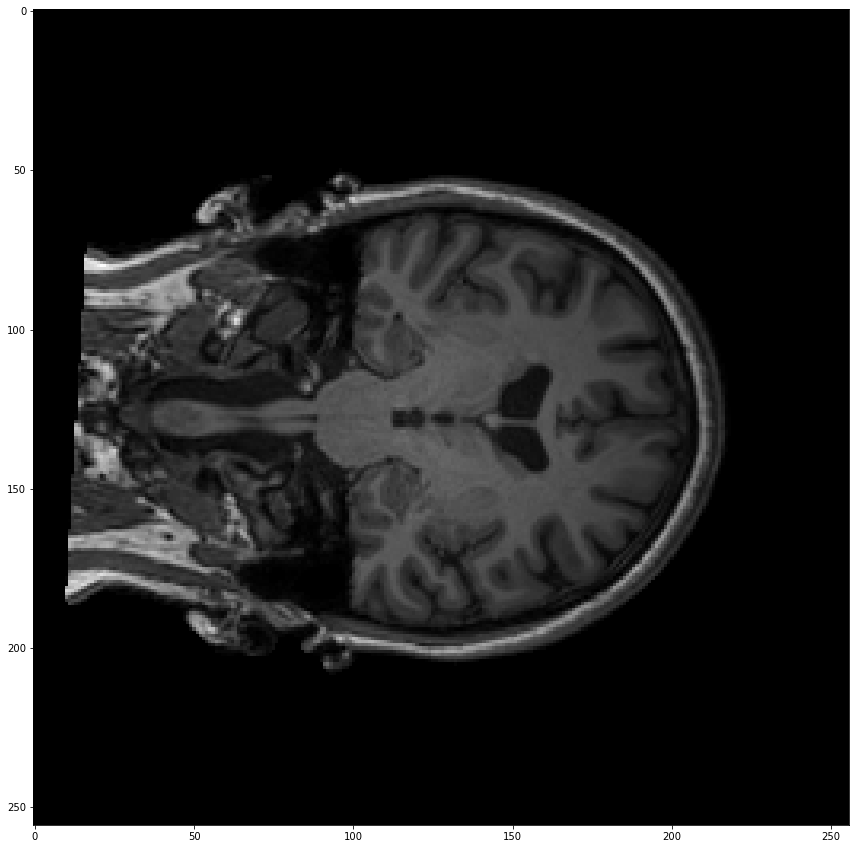

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(ww , cmap='gray')

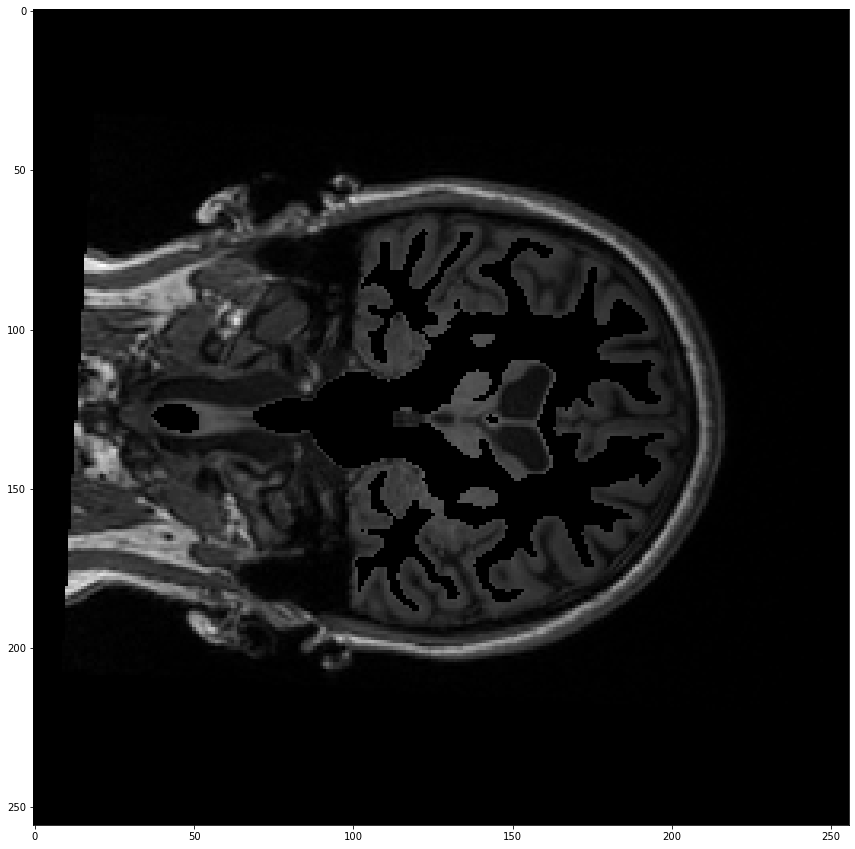

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(zz, cmap='gray')

In [28]:
yy = np.copy(maskPredictScaled)
yy[yy>0.9] = 1.0
yy[yy<=0.9] = 0.0


In [29]:
 for x in range(yy.shape[0]):
        for y in range(yy.shape[1]):
            # for the given pixel at w,h, lets check its value against the threshold
            if yy[x,y] == 0: #note that the first parameter is actually a tuple object
                # lets set this to zero
                aa[x,y] = 0

In [30]:
 for x in range(maskSlice.shape[0]):
        for y in range(maskSlice.shape[1]):
            # for the given pixel at w,h, lets check its value against the threshold
            if maskSlice[x,y] == 1: #note that the first parameter is actually a tuple object
                # lets set this to zero
                qq[x,y] = 0

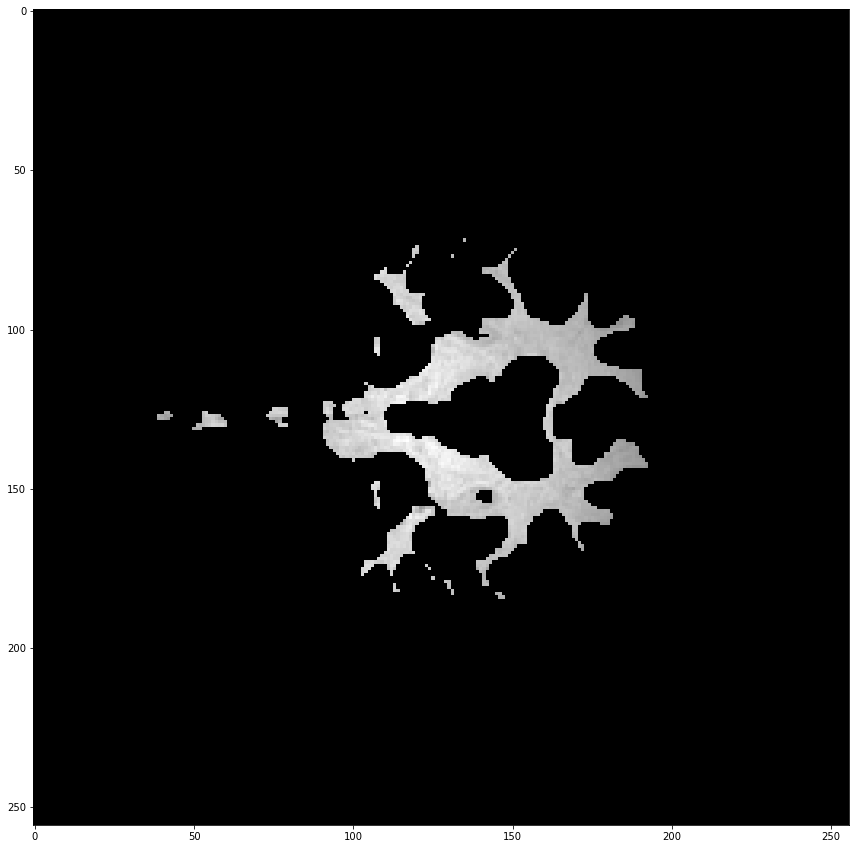

In [31]:
plt.figure(figsize=(15,15))
plt.imshow(aa, cmap='gray')

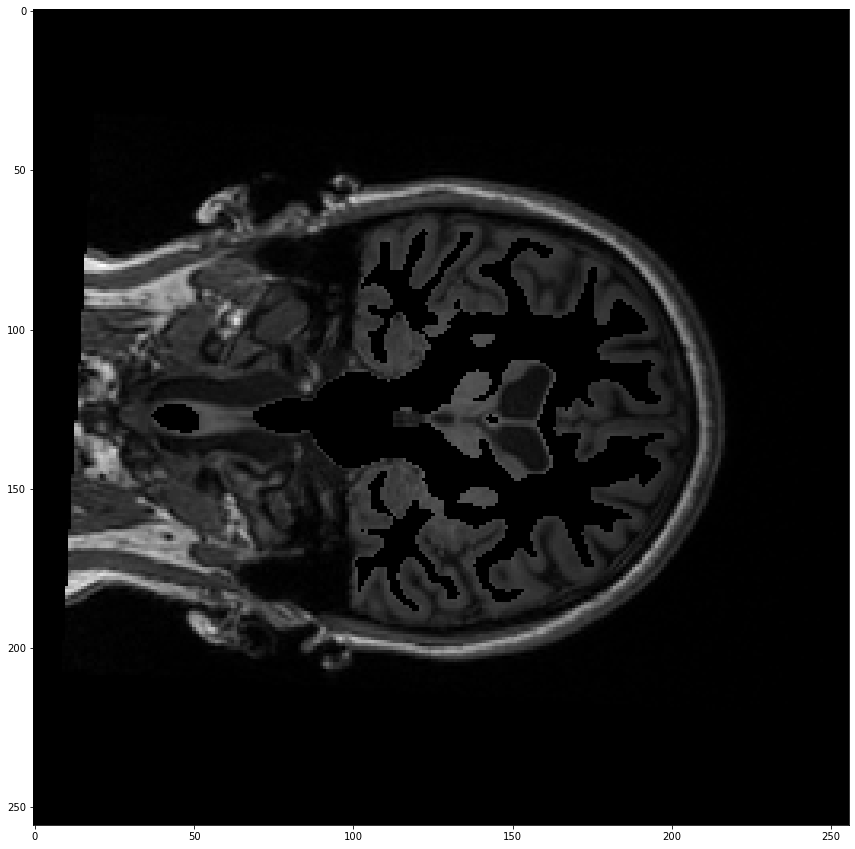

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(qq, cmap='gray')